# Note on Gridworld Action Space Restriction
There is a problem, potentially, since staying in a location is not an allowable action (technically) but an agent could repeatedly choose an invalid action (if the invalid action is selectable in the first place). So I need to further prune the set of actions, depending on the state, but I do not want to do so in a way that is manual.

The way to do this is to count the number of non-corner edge states and account for that in the allowable set of actions. Since the area of the grid is length^2, the perimeter is 4$*$length, and the number of non-corner edge states is therefore 4$*$(length-1) and the number of corners is 4. Therefore, the number of allowable actions (dependent on state) is: $\left(4*{length}^2-4*length\right)*4+4*(length-1)*3+4*2$ so for $length=5$ we have $(100-20)*4+16*3+8=320+48+8=376$ actions.

<IPython.core.display.Javascript object>


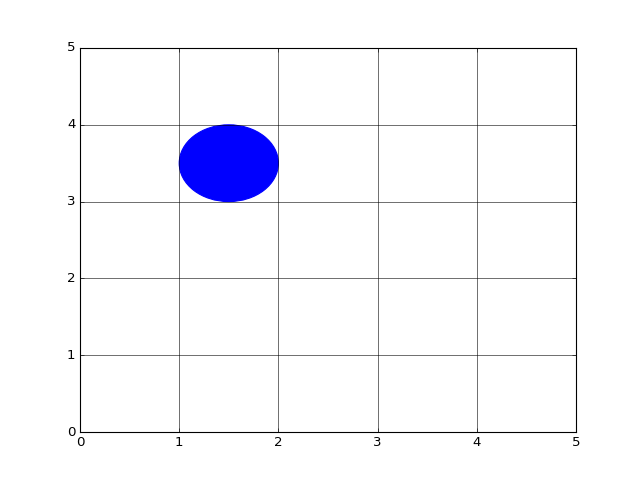

<IPython.core.display.Javascript object>


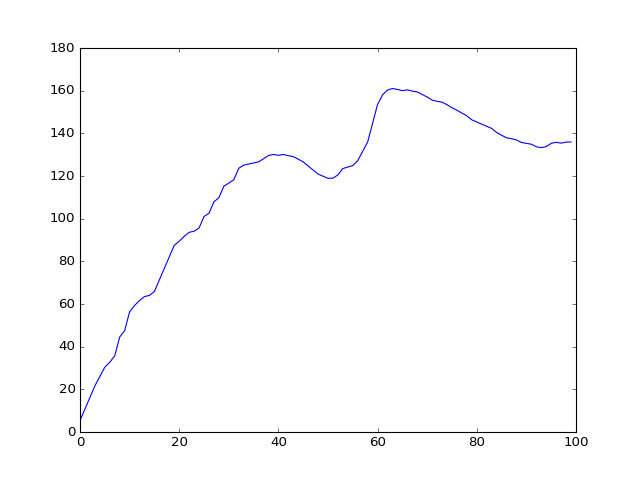

/home/floppsy/anaconda3/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:318: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  out = N.ndarray.__getitem__(self, index)


[1 2 4]
x low
[1 2 4]
x low
[1 2 4]
x low
[1 2 4]
[1 2 4]
x low
[1 2 4]
[1 2 3 4]
[1 2 3 4]
[1 2 4]
[1 2 3 4]
[1 2 4]
[1 2 3 4]
[1 2 3 4]
[1 2 3 4]
[2 3 4]
[1 2 3 4]
[1 2 4]
x low
[1 2 4]
x low
[1 2 4]
x low
[1 2 4]
[1 2 3 4]
[1 2 3 4]
[1 2 3 4]
[2 3 4]
[2 4]
[1 2 4]
[2 4]
[1 2 4]
[1 2 3 4]
[1 2 4]
[2 4]
x low
[2 4]
[1 2 4]
[2 4]
[2 3 4]
y high
[2 3 4]
y high
[2 3 4]
[2 4]
y high
[2 4]
[2 3 4]
[2 3 4]
[1 2 3 4]
[1 2 3 4]
[1 2 3 4]
[1 2 3]
[1 2 3]
[1 3]
x high
[1 3]
x high
[1 3]
[1 3 4]
y low
[1 3 4]
[1 3 4]
[1 3 4]
[1 2 3 4]
[1 2 3 4]
[1 2 3 4]
[1 2 3 4]
[1 2 4]
x low
[1 2 4]
[1 2 4]
x low
[1 2 4]
[1 2 4]
[1 2 3 4]
[1 2 3 4]
[1 2 3 4]
[1 2 3 4]
[1 2 3 4]
[1 2 3 4]
[1 2 3 4]
[1 2 3]
x high
[1 2 3]
[1 2 3]
[1 2 3 4]
[1 2 3 4]
[1 2 3]
[1 2 3]
[1 2 3]
[1 2 3]
x high
[1 2 3]
[1 3]
[1 3 4]
y low
[1 3 4]
y low
[1 3 4]
y low
[1 3 4]
[1 3]
[1 2 3]
[1 2 3]
[1 2 3 4]
[1 2 3 4]
[2 3 4]
[2 3 4]
y high
[2 3 4]
[2 3 4]
[2 3 4]
[2 3 4]
[2 4]
[2 3 4]
[2 3 4]
[2 3 4]


In [23]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import matplotlib.ticker as plticker

class gridworld(gym.Env):
  metadata = {'render.modes': ['human']}

  def __init__(self): 
    self.gridnum = 5 #size of gridworld
    self.location_x = np.random.randint(0,self.gridnum)+0.5
    self.location_y = np.random.randint(0,self.gridnum)+0.5
    self.action = 0 # no initial action until computed
    self.actionSet = np.array([1,2,3,4])
    self.episode_length = 100
    self.num_episodes = 10
    self.my_alpha = 0.3
    self.my_gamma = 0.9
    self.my_reward = np.matrix('3.3 8.8 4.4 5.4 1.5;1.5 3.0 2.3 1.9 0.5;0.1 0.7 0.7 0.4 -0.4; -1.0 -0.4 -0.4 -0.6 -1.2; -1.9 -1.3 -1.2 -1.4 -2.0') 
    self.my_reward_model = np.random.rand(self.gridnum,self.gridnum)
    self.my_q_function = np.random.rand(self.gridnum,self.gridnum, 4)# randomly initialized via reward model
    self.my_reward_log = np.random.rand(self.num_episodes, self.episode_length) # used to store reward for each time step
    pass
  def get_allowed_actions(self):
    if self.location_x == 0.5 and self.location_y == 0.5:
        allowed_actions = np.array([1,4])
    elif self.location_x == 0.5 and self.location_y == self.gridnum - 0.5:
        allowed_actions = np.array([2,4])
    elif self.location_x == self.gridnum - 0.5 and self.location_y == 0.5:
        allowed_actions = np.array([1,3])
    elif self.location_x == self.gridnum - 0.5 and self.location_y == self.gridnum - 0.5:
        allowed_actions = np.array([2,3])
    elif self.location_x == 0.5:
        allowed_actions = np.array([1,2,4])
    elif self.location_x == self.gridnum - 0.5:
        allowed_actions = np.array([1,2,3])
    elif self.location_y == 0.5:
        allowed_actions = np.array([1,3,4])
    elif self.location_y == self.gridnum - 0.5:
        allowed_actions = np.array([2,3,4])
    else:
        allowed_actions = np.array([1,2,3,4])
    return allowed_actions
  def step_check(self, location_x, location_y, gridnum):
    if self.location_x < 0: # this part of the method is for preventing the agent from moving out of gridworld
        self.location_x = 0.5
        print('x low')
    elif self.location_x > self.gridnum:
        self.location_x = self.gridnum - 0.5
        print('x high')
    if self.location_y < 0:
        self.location_y = 0.5
        print('y low')
    elif self.location_y > self.gridnum:
        self.location_y = self.gridnum - 0.5    
        print('y high')
    pass
  def step(self):
    if self.action == 1: # this part of the method is to select the desired deterministic action
        self.location_y += 1
    elif self.action == 2:
        self.location_y += -1
    elif self.action == 3:
        self.location_x += -1
    elif self.action == 4:
        self.location_x += 1
    self.step_check(self.location_x,self.location_y,self.gridnum)
    if np.random.rand() <= 0.1: # this part of the method is to enforce a 10% chance of a random action
        self.action = int(np.random.randint(1,5))
    self.step_check(self.location_x,self.location_y,self.gridnum)
    pass #return [(self.location_x, self.location_y)]
  def next_states(self):
    next_locations_x
    next_locations_y
    #np.unique([self.step(1),self.step(2),self.step(3),self.step(4)]
    pass
  def update_reward_model(self,location_x,location_y):
    self.my_reward_model[location_x,location_y] = self.my_reward[location_x,location_y]
    pass
  def calculate_my_q_function(self,action,location_x,location_y):
#    self.q_function([action,location_x,location_y]) = self.my_reward[location_x,location_y]\
#    +self.my_gamma*self.q_function([next_action,next_location_x,next_location_y])
    pass
  def update_my_q_function(self,action,location_x,location_y):
    
    pass
  def reset(self):
    pass
  def render(self, mode='human', close=False):
    pass

world = gridworld()

fig, (ax)=plt.subplots()#do not know alternative to command fig.canvas.draw() to have independent subplots shown
fig1, (ax1)=plt.subplots()


intervals = float(1/world.gridnum)# 5x5 grid, dimension of grid affects size
loc = plticker.MultipleLocator(base=intervals)
ax.xaxis.set_major_locator(loc)
ax.set_xlim(0, world.gridnum)
ax.yaxis.set_major_locator(loc)
ax.set_ylim(0, world.gridnum)

#Initialization
ax.clear()
ax.grid(which='major', axis='both', linestyle='-')
circle2 = plt.Circle((world.location_x, world.location_y), 0.5, color='blue')#rand initialization
ax = fig.gca()
ax.add_artist(circle2)
fig.canvas.draw()

# initial reward
for i in range(0,world.episode_length - 1):
    world.my_reward_log[0,i] = world.my_reward[(world.location_x,world.location_y)]
#    world.my_q_function[world.location_x,world.location_y] = \
#    world.my_q_function[world.location_x,world.location_y] + world.my_alpha *\
#    (world.my_reward_log[0,i]*world.my_gamma*(??)-world.my_q_function[world.location_x,world.location_y])
    ax.clear()
    ax.grid(which='major', axis='both', linestyle='-')
    my_allowed_actions = world.get_allowed_actions()
    test = my_allowed_actions.shape[0]
    test2 = np.random.randint(0,test)
    world.action = my_allowed_actions[test2]
    print(my_allowed_actions)
    world.action = np.random.randint(1,5)
    world.location_x
    world.location_y
    world.step()
    circle2 = plt.Circle((world.location_x, world.location_y), 0.5, color='blue')
    ax = fig.gca()
    ax.add_artist(circle2)
    fig.canvas.draw()
ax1.plot(np.cumsum(world.my_reward_log[0,:]))

In [18]:
import numpy as np
x  = np.array([1,2,3])
print(x)
print(x.shape[0])

[1 2 3]
3
